In [1]:
import scvelo as scv
import scanpy as sc
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists

In [2]:
datasets = ['DentateGyrus'] #, 'DentateGyrus', 'Hindbrain_pons', 'HumanBoneMarrow', 'RetinaDevelopment', 'Pancreas_without_cc', 'IntestinalOrganoids 

DentateGyrus
Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/64 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:05:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


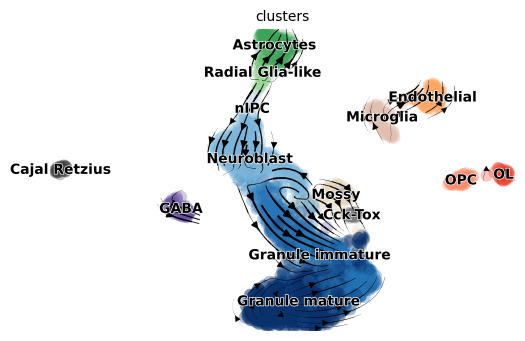

All Done.


In [3]:
for dataset in datasets:
    print(dataset)
    # Load and setup data:
    data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
    save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, color='clusters', dpi=100)
    # Calculate performance:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    mean_score = cross_boundary_correctness(adata = adata, k_cluster = 'clusters',
                               k_velocity = 'velocity', cluster_edges = ground_truth)[1]
    now = datetime.now()
    date_time = now.strftime("%Y%m%d-%H%M%S")
    # Save results of benchmarking run:
    all_params = {'Model': 'scVelo_dynamical'}
    all_params['dataset'] = dataset
    all_params['mean_score'] = mean_score
    new_tab = pd.DataFrame(columns = list(all_params.keys()), index = [date_time])
    new_tab.loc[date_time,:] = list(all_params.values())
    path_to_file = save_dir + 'scVeloBenchmarking_results.csv'
    file_exists = exists(path_to_file)
    new_tab = new_tab.astype(str)
    if file_exists:
        new_tab.to_csv(path_to_file, mode='a', index=True, header=False)
    else:
        new_tab.to_csv(path_to_file, sep = ',')
print('All Done.')

computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


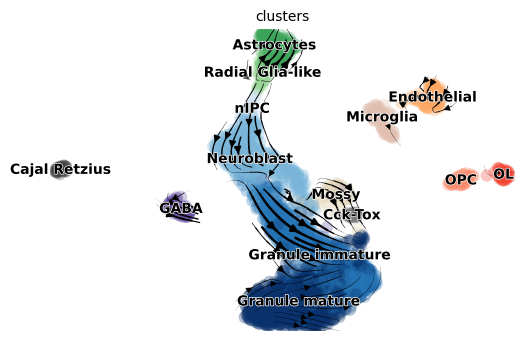

In [4]:
adata.var['velocity_genes'] = True
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters', dpi=100)

In [8]:
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'

In [9]:
with open(data_dir + dataset + '/' + dataset + '_velocity_genes.pickle', 'wb') as handle:
    pickle.dump(adata.var.index[adata.var['velocity_genes']], handle, protocol=pickle.HIGHEST_PROTOCOL)

(array([1.787639e+06, 1.046570e+06, 9.048510e+05, 6.685460e+05,
        3.775370e+05, 3.338000e+03, 3.534000e+03, 3.343000e+03,
        1.877000e+03, 1.730000e+02]),
 array([ 0.        ,  4.08706949,  8.17413898, 12.26120847, 16.34827795,
        20.43534744, 24.52241693, 28.60948642, 32.69655591, 36.7836254 ,
        40.87069488]),
 <BarContainer object of 10 artists>)

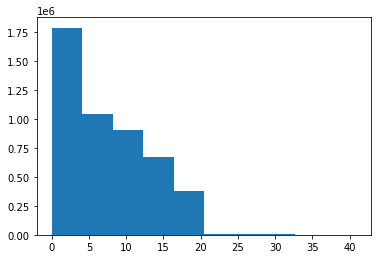

In [17]:
import matplotlib.pyplot as plt
plt.hist(adata.layers['fit_t'].flatten())

(array([3.836864e+06, 5.591660e+05, 2.319340e+05, 1.033400e+05,
        3.899700e+04, 1.777900e+04, 7.812000e+03, 1.136000e+03,
        3.160000e+02, 6.400000e+01]),
 array([ 0.        ,  3.0935493 ,  6.1870986 ,  9.2806479 , 12.37419719,
        15.46774649, 18.56129579, 21.65484509, 24.74839439, 27.84194369,
        30.93549298]),
 <BarContainer object of 10 artists>)

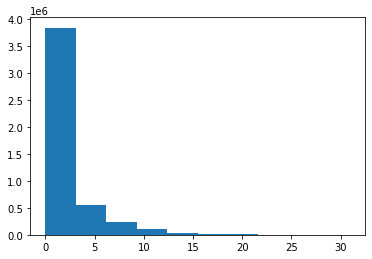

In [18]:
import matplotlib.pyplot as plt
plt.hist(adata.layers['fit_tau'].flatten())

(array([3.881598e+06, 6.821980e+05, 1.632230e+05, 4.974800e+04,
        7.696000e+03, 6.128000e+03, 2.626000e+03, 1.830000e+03,
        5.200000e+01, 2.309000e+03]),
 array([  0.        ,  13.77511076,  27.55022151,  41.32533227,
         55.10044303,  68.87555378,  82.65066454,  96.4257753 ,
        110.20088605, 123.97599681, 137.75110757]),
 <BarContainer object of 10 artists>)

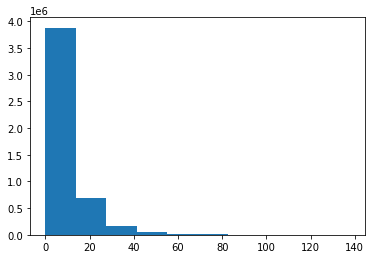

In [19]:
import matplotlib.pyplot as plt
plt.hist(adata.layers['fit_tau_'].flatten())

In [11]:
adata

AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'